# Training Data Analysis (Surrogate Model)


This notebook analyzes the **training data used for the surrogate models**.
It regenerates the key descriptive statistics, figures, and tables referenced in the thesis training-data section.


## Generated assets


Figures (written to `diagram/` in the thesis repo):
- `training_fitness_distribution.pdf`
- `training_test_pass_rates.pdf`
- `training_class_imbalance.pdf`
- `training_project_distribution.pdf`


Tables (written to `tables/` in the thesis repo and duplicated as CSV):
- `training_dataset_overview.tex` / `.csv`
- `training_test_statistics.tex` / `.csv`
- `training_project_statistics.tex` / `.csv`


The notebook reads a pre-aggregated training dataset (one row per chromosome) and summarizes
its size, project coverage, fitness distribution, and test outcome characteristics.

In [ ]:
# Common imports and configuration
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional export of figures/tables directly into the thesis repository
EXPORT_TO_THESIS = True  # set to False to keep everything local to this repo

# Hard-coded thesis root
THESIS_ROOT = Path('/Users/stefan/Workspace/bauers-ma/thesis/').resolve()

TABLES_DIR = THESIS_ROOT / 'tables'
DIAGRAM_DIR = THESIS_ROOT / 'diagram'

# Location of pre-aggregated training data (pickled DataFrame)
TRAINING_DATA_PATH = Path('../model_training/df.pickle')
if not TRAINING_DATA_PATH.exists():
    raise FileNotFoundError(f'Training data pickle not found: {TRAINING_DATA_PATH}')

# Load training data
df = pd.read_pickle(TRAINING_DATA_PATH)
pd.set_option('display.max_columns', None)

print(f'Loaded training data from: {TRAINING_DATA_PATH}')
print(f'Total samples: {len(df):,}')
print(f'Number of columns: {len(df.columns)}')

Loaded training data from: ../model_training/df.pickle
Total samples: 19,417,760
Number of columns: 34


Saved: /Users/stefan/Workspace/bauers-ma/thesis/diagram/training_project_distribution.pdf


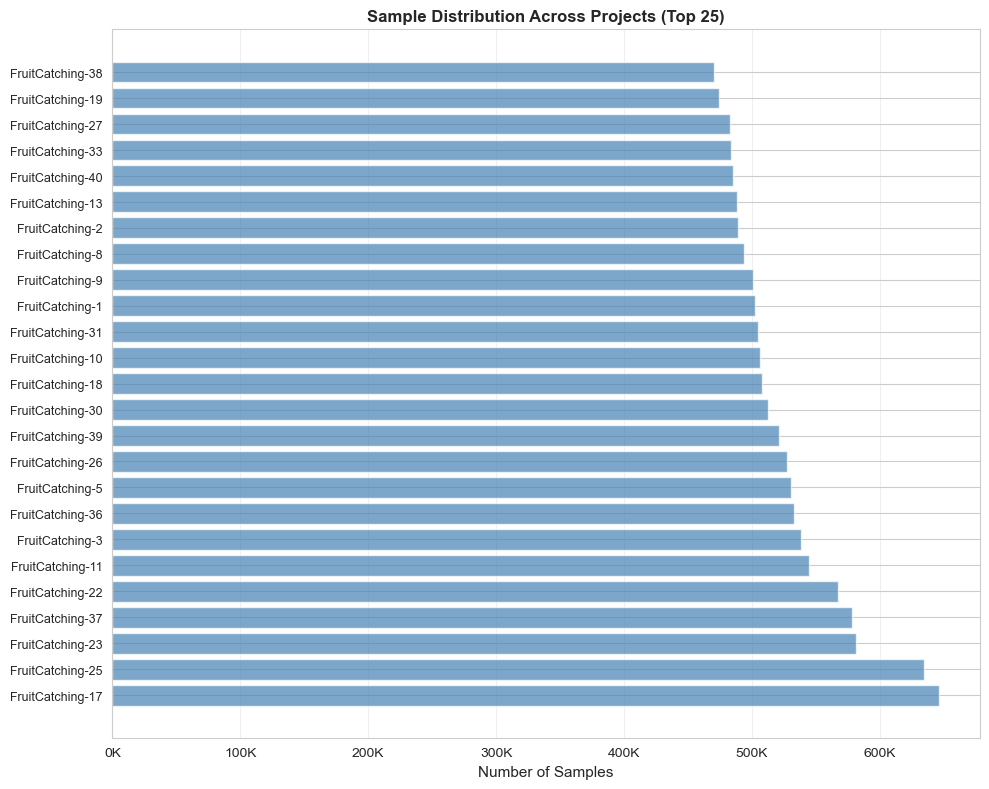

In [29]:
# Figure 4: Project Distribution
project_counts = df['project'].value_counts()
projects_with_data = project_counts[project_counts > 0]

fig, ax = plt.subplots(figsize=(10, 8))
top_n = min(25, len(projects_with_data))
top_projects = projects_with_data.head(top_n)

bars = ax.barh(range(len(top_projects)), top_projects.values, color='steelblue', alpha=0.7)
ax.set_yticks(range(len(top_projects)))
ax.set_yticklabels(top_projects.index, fontsize=9)
ax.set_xlabel('Number of Samples', fontsize=11)
ax.set_title(f'Sample Distribution Across Projects (Top {top_n})', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Format x-axis to show numbers in thousands
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K'))

plt.tight_layout()

if EXPORT_TO_THESIS:
    DIAGRAM_DIR.mkdir(parents=True, exist_ok=True)
    out_path = DIAGRAM_DIR / 'training_project_distribution.pdf'
    plt.savefig(out_path, format='pdf', bbox_inches='tight', dpi=300)
    print(f"Saved: {out_path}")
else:
    print("EXPORT_TO_THESIS is False – figure not saved to thesis directory.")

plt.show()

In [ ]:
# Table 3: Project Sample Distribution
project_counts = df['project'].value_counts()
projects_with_data = project_counts[project_counts > 0]

project_stats = {
    'Metric': [
        'Projects with Data',
        'Projects without Data',
        'Mean Samples per Project',
        'Median Samples per Project',
        'Std. Dev.',
        'Min Samples',
        'Max Samples'
    ],
    'Value': [
        f'{len(projects_with_data)}',
        f'{len(project_counts) - len(projects_with_data)}',
        f'{projects_with_data.mean():,.0f}',
        f'{projects_with_data.median():,.0f}',
        f'{projects_with_data.std():,.0f}',
        f'{projects_with_data.min():,}',
        f'{projects_with_data.max():,}'
    ]
}

project_table = pd.DataFrame(project_stats)
print("\nTable 3: Project Distribution Statistics")
print(project_table.to_string(index=False))

if EXPORT_TO_THESIS:
    TABLES_DIR.mkdir(parents=True, exist_ok=True)
    latex_table = project_table.to_latex(index=False, column_format='lr', escape=False)
    tex_path = TABLES_DIR / 'training_project_statistics.tex'
    csv_path = TABLES_DIR / 'training_project_statistics.csv'
    tex_path.write_text(latex_table)
    project_table.to_csv(csv_path, index=False)
    print(f"\nSaved: {tex_path}")
    print(f"Saved: {csv_path}")


Table 3: Project Distribution Statistics
                    Metric   Value
        Projects with Data      41
     Projects without Data      41
  Mean Samples per Project 473,604
Median Samples per Project 484,897
                 Std. Dev.  83,354
               Min Samples 196,933
               Max Samples 645,850

Saved: /Users/stefan/Workspace/bauers-ma/thesis/tables/training_project_statistics.tex
Saved: /Users/stefan/Workspace/bauers-ma/thesis/tables/training_project_statistics.csv


In [ ]:
# Table 2: Test Outcome Statistics
test_cols = [col for col in df.columns if col.startswith('test')]

test_stats = []
for test in test_cols:
    true_count = (df[test] == True).sum()
    false_count = (df[test] == False).sum()
    total = true_count + false_count
    pass_rate = (true_count / total) * 100
    imbalance_ratio = max(true_count, false_count) / min(true_count, false_count) if min(true_count, false_count) > 0 else float('inf')
    test_stats.append({
        'Test': test.replace('test', ''),
        'Pass Count': f'{true_count:,}',
        'Fail Count': f'{false_count:,}',
        'Pass Rate (%)': f'{pass_rate:.1f}',
        'Imbalance Ratio': f'{imbalance_ratio:.2f}'
    })

test_table = pd.DataFrame(test_stats)
test_table = test_table.sort_values('Pass Rate (%)', ascending=False, key=lambda x: x.str.replace(',', '').astype(float))

print("\nTable 2: Test Outcome Statistics")
print(test_table.to_string(index=False))

if EXPORT_TO_THESIS:
    TABLES_DIR.mkdir(parents=True, exist_ok=True)
    latex_table = test_table.to_latex(index=False, column_format='lrrrr', escape=False)
    tex_path = TABLES_DIR / 'training_test_statistics.tex'
    csv_path = TABLES_DIR / 'training_test_statistics.csv'
    tex_path.write_text(latex_table)
    pd.DataFrame(test_stats).to_csv(csv_path, index=False)
    print(f"\nSaved: {tex_path}")
    print(f"Saved: {csv_path}")


Table 2: Test Outcome Statistics
                      Test Pass Count Fail Count Pass Rate (%) Imbalance Ratio
       FruitInitialization 16,329,203  3,088,557          84.1            5.29
              AppleFalling 13,840,988  5,576,772          71.3            2.48
             BananaFalling 12,622,769  6,794,991          65.0            1.86
                AppleSpawn 10,917,747  8,500,013          56.2            1.28
             OnlyOneBanana 10,897,205  8,520,555          56.1            1.28
              OnlyOneApple 10,892,805  8,524,955          56.1            1.28
               BananaSpawn 10,839,313  8,578,447          55.8            1.26
BananaSpawnRandomXPosition  9,354,742 10,063,018          48.2            1.08
       AppleFallingDetails  9,341,270 10,076,490          48.1            1.08
 AppleSpawnRandomXPosition  9,338,469 10,079,291          48.1            1.08
                  MoveBowl  9,030,836 10,386,924          46.5            1.15
      BananaFallin

In [ ]:
# Table 1: Dataset Overview Statistics
project_counts = df['project'].value_counts()
projects_with_data = project_counts[project_counts > 0]
test_cols = [col for col in df.columns if col.startswith('test')]

overview_stats = {
    'Metric': [
        'Total Samples',
        'Number of Projects',
        'Number of Tests',
        'Mean Fitness',
        'Median Fitness',
        'Std. Dev. Fitness',
        'Min Fitness',
        'Max Fitness'
    ],
    'Value': [
        f'{len(df):,}',
        f'{len(projects_with_data)}',
        f'{len(test_cols)}',
        f'{df["fitness"].mean():.2f}',
        f'{df["fitness"].median():.2f}',
        f'{df["fitness"].std():.2f}',
        f'{df["fitness"].min():.2f}',
        f'{df["fitness"].max():.2f}'
    ]
}

overview_table = pd.DataFrame(overview_stats)
print("Table 1: Dataset Overview")
print(overview_table.to_string(index=False))

if EXPORT_TO_THESIS:
    TABLES_DIR.mkdir(parents=True, exist_ok=True)
    latex_table = overview_table.to_latex(index=False, column_format='lr', escape=False)
    tex_path = TABLES_DIR / 'training_dataset_overview.tex'
    csv_path = TABLES_DIR / 'training_dataset_overview.csv'
    tex_path.write_text(latex_table)
    overview_table.to_csv(csv_path, index=False)
    print(f"\nSaved: {tex_path}")
    print(f"Saved: {csv_path}")

Table 1: Dataset Overview
            Metric      Value
     Total Samples 19,417,760
Number of Projects         41
   Number of Tests         28
      Mean Fitness      20.51
    Median Fitness      21.03
 Std. Dev. Fitness       3.58
       Min Fitness      11.14
       Max Fitness      27.93

Saved: /Users/stefan/Workspace/bauers-ma/thesis/tables/training_dataset_overview.tex
Saved: /Users/stefan/Workspace/bauers-ma/thesis/tables/training_dataset_overview.csv


Saved: /Users/stefan/Workspace/bauers-ma/thesis/diagram/training_class_imbalance.pdf


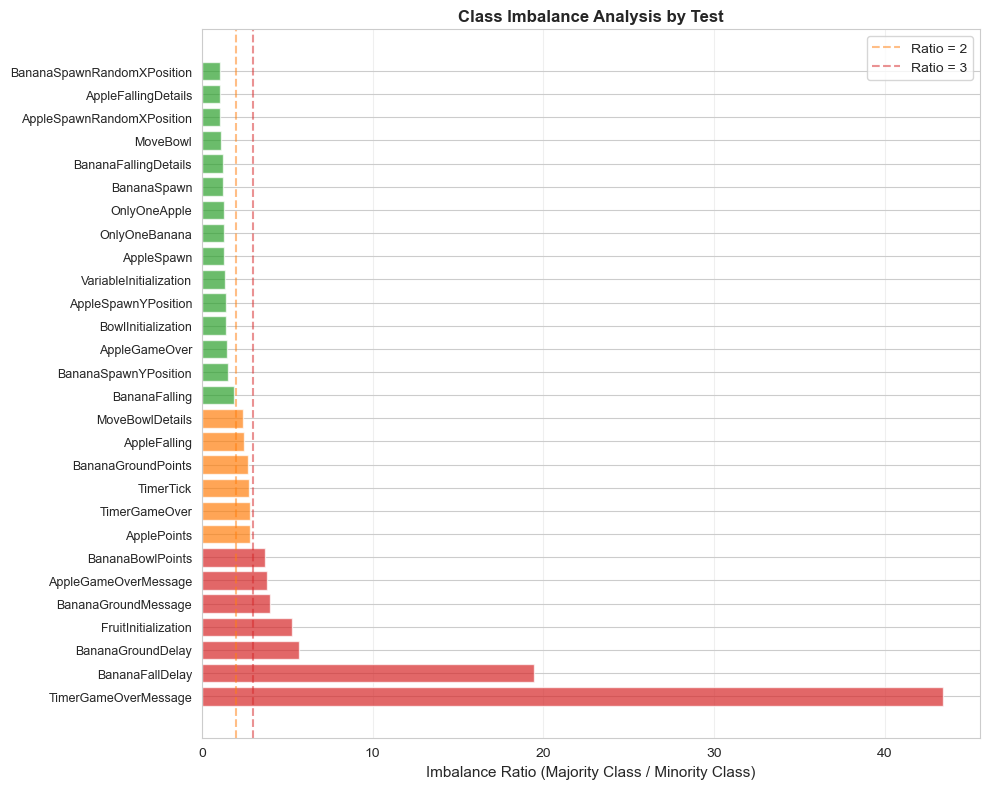

In [ ]:
# Figure 3: Class Imbalance
test_cols = [col for col in df.columns if col.startswith('test')]

imbalance_data = []
for test in test_cols:
    true_count = (df[test] == True).sum()
    false_count = (df[test] == False).sum()
    total = true_count + false_count
    imbalance_ratio = max(true_count, false_count) / min(true_count, false_count) if min(true_count, false_count) > 0 else float('inf')
    imbalance_data.append({
        'Test': test.replace('test', ''),
        'Imbalance Ratio': imbalance_ratio
    })

imbalance_df = pd.DataFrame(imbalance_data)
imbalance_df = imbalance_df.sort_values('Imbalance Ratio', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#d62728' if ratio > 3 else '#ff7f0e' if ratio > 2 else '#2ca02c' for ratio in imbalance_df['Imbalance Ratio']]
bars = ax.barh(range(len(imbalance_df)), imbalance_df['Imbalance Ratio'], color=colors, alpha=0.7)
ax.set_yticks(range(len(imbalance_df)))
ax.set_yticklabels(imbalance_df['Test'], fontsize=9)
ax.set_xlabel('Imbalance Ratio (Majority Class / Minority Class)', fontsize=11)
ax.set_title('Class Imbalance Analysis by Test', fontsize=12, fontweight='bold')
ax.axvline(x=2, color='#ff7f0e', linestyle='--', alpha=0.5, linewidth=1.5, label='Ratio = 2')
ax.axvline(x=3, color='#d62728', linestyle='--', alpha=0.5, linewidth=1.5, label='Ratio = 3')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()

if EXPORT_TO_THESIS:
    DIAGRAM_DIR.mkdir(parents=True, exist_ok=True)
    out_path = DIAGRAM_DIR / 'training_class_imbalance.pdf'
    plt.savefig(out_path, format='pdf', bbox_inches='tight', dpi=300)
    print(f"Saved: {out_path}")

plt.show()

Saved: /Users/stefan/Workspace/bauers-ma/thesis/diagram/training_test_pass_rates.pdf


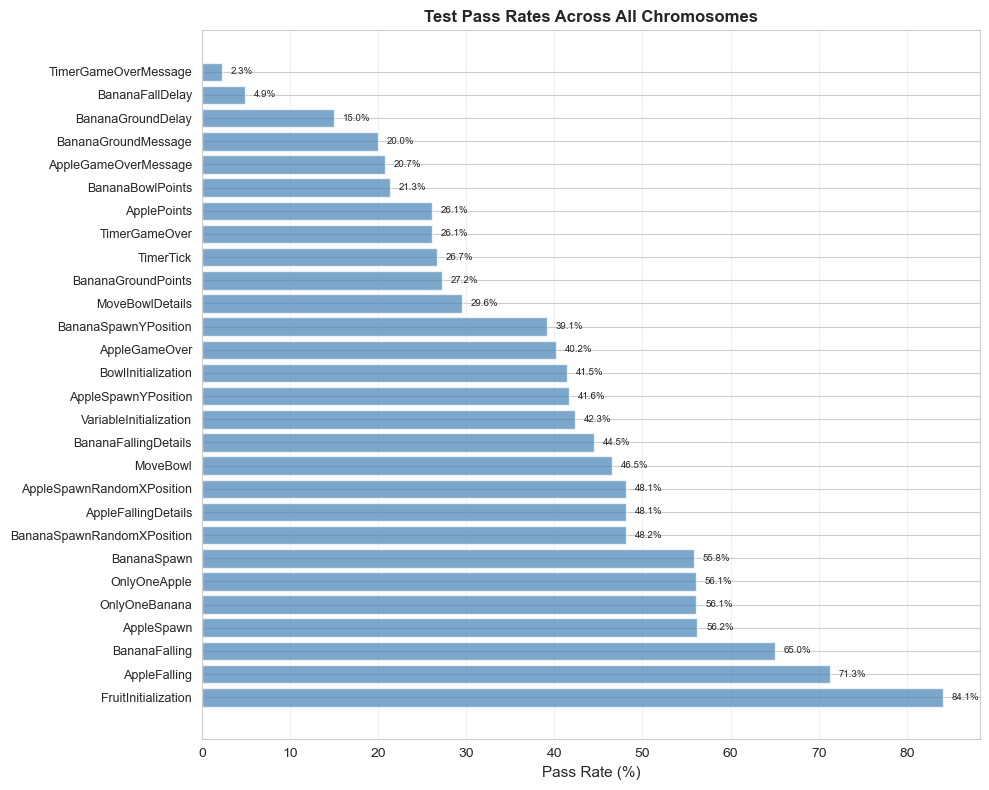

In [ ]:
# Figure 2: Test Pass Rates
test_cols = [col for col in df.columns if col.startswith('test')]

pass_rates = {}
for test in test_cols:
    total = len(df)
    passed = (df[test] == True).sum()
    pass_rates[test] = (passed / total) * 100

pass_rates_sorted = dict(sorted(pass_rates.items(), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(figsize=(10, 8))
tests = list(pass_rates_sorted.keys())
rates = list(pass_rates_sorted.values())

bars = ax.barh(range(len(tests)), rates, color='steelblue', alpha=0.7)
ax.set_yticks(range(len(tests)))
ax.set_yticklabels([t.replace('test', '') for t in tests], fontsize=9)
ax.set_xlabel('Pass Rate (%)', fontsize=11)
ax.set_title('Test Pass Rates Across All Chromosomes', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

for i, (bar, rate) in enumerate(zip(bars, rates)):
    ax.text(rate + 1, i, f'{rate:.1f}%', va='center', fontsize=7)

plt.tight_layout()

if EXPORT_TO_THESIS:
    DIAGRAM_DIR.mkdir(parents=True, exist_ok=True)
    out_path = DIAGRAM_DIR / 'training_test_pass_rates.pdf'
    plt.savefig(out_path, format='pdf', bbox_inches='tight', dpi=300)
    print(f"Saved: {out_path}")

plt.show()

Saved: /Users/stefan/Workspace/bauers-ma/thesis/diagram/training_fitness_distribution.pdf


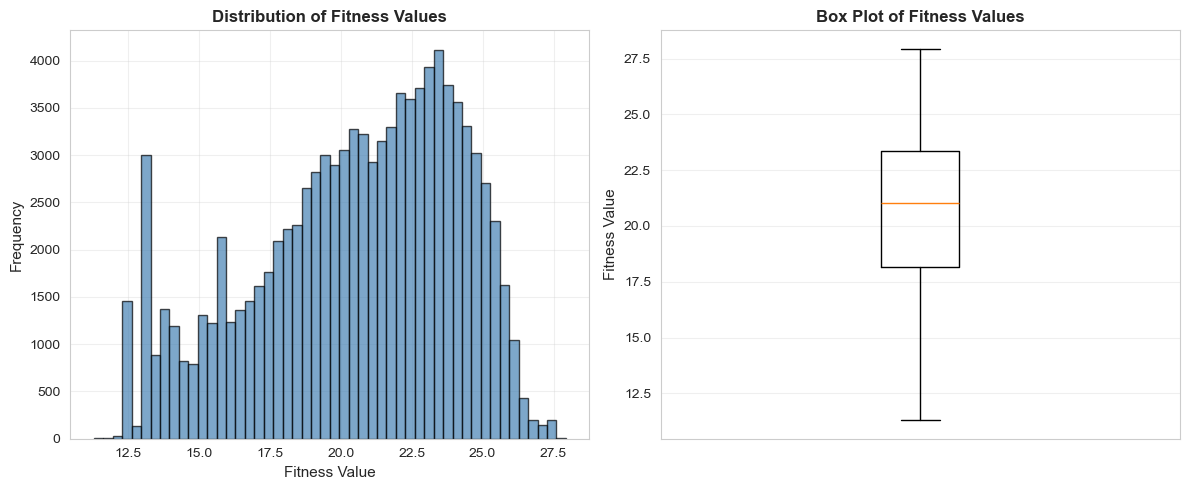

In [ ]:
# Figure 1: Fitness Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sample_size = min(100000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

axes[0].hist(df_sample['fitness'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Fitness Value', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Fitness Values', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(df_sample['fitness'], vert=True)
axes[1].set_ylabel('Fitness Value', fontsize=11)
axes[1].set_title('Box Plot of Fitness Values', fontsize=12, fontweight='bold')
axes[1].set_xticks([])  # hide meaningless x-axis tick labeled "1"
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

if EXPORT_TO_THESIS:
    DIAGRAM_DIR.mkdir(parents=True, exist_ok=True)
    out_path = DIAGRAM_DIR / 'training_fitness_distribution.pdf'
    plt.savefig(out_path, format='pdf', bbox_inches='tight', dpi=300)
    print(f"Saved: {out_path}")

plt.show()